In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from model import *
from dataset import *
import util
import json
from collections import defaultdict

# Evaluate the model on the entire dataset
data = HD5Dataset('../data/data_dragon.hd5', seed=42, features=["FirstCharge", "CumulativeCharge", "Time",
            "VertexX", "VertexY", "VertexZ", "RecoX",
"RecoZ", "RecoAzimuth", "RecoZenith"])

In [3]:
with open('training/hd5-860835/config.json') as f:
    settings = json.load(f)

In [4]:
data = util.dataset_from_config(settings)

/media/dominik/d/uni/uare/icecube/NuIntClassification/dataset/hd5.py:316: RuntimeWarning: invalid value encountered in less
  idx_removed = np.where(np.logical_and((track_length < min_track_length), has_track_length))[0]
/media/dominik/d/uni/uare/icecube/NuIntClassification/dataset/hd5.py:322: RuntimeWarning: invalid value encountered in greater
  idx_removed = np.where(np.logical_and((cascade_energy > max_cascade_energy), has_track_length))


After Track Length filter 1333960 / 2202957 events remain.
After Cascade Energy filter 1167113 / 2202957 events remain.
Reduced dataset to 326328 samples per class (652656 / 2202957)
Created sha1 hash for features and data file c7186ad6f4095a7ceb2168696ef104bbe0381efa
Loaded feature memmap ./memmaps/hd5_features_c7186ad6f4095a7ceb2168696ef104bbe0381efa.
Created distances memmap ./memmaps/hd5_distances_c7186ad6f4095a7ceb2168696ef104bbe0381efa.


In [5]:
model = util.model_from_config(settings)

In [13]:
model.load_weights('training/hd5-860835/model_weights.h5')

In [14]:
model.weights

[<tf.Variable 'gaussian_adjacency_matrix/sigma:0' shape=(1,) dtype=float32, numpy=array([0.35142273], dtype=float32)>,
 <tf.Variable 'graph_convolution/dense/kernel:0' shape=(11, 64) dtype=float32, numpy=
 array([[ 0.2239214 ,  0.15596068, -0.13438588, -0.07833476,  0.14623208,
         -0.08545016, -0.02621705, -0.19662471,  0.15228847, -0.20730625,
         -0.09103765, -0.16213174, -0.22246753,  0.04835239, -0.0158903 ,
         -0.13461098, -0.0386467 , -0.25373593,  0.0026829 , -0.26437947,
          0.26145646, -0.00076191,  0.18259798,  0.06007466, -0.17173089,
          0.2913055 , -0.02826076,  0.07315319,  0.06424043,  0.16374806,
          0.20040113,  0.01533565, -0.23864836,  0.17922196, -0.00672318,
         -0.20244783,  0.03283402,  0.23020889,  0.04662801,  0.23188503,
          0.05235031, -0.23137029,  0.15334603,  0.0786277 ,  0.0889988 ,
         -0.27830297,  0.25397697,  0.00536071, -0.2702963 , -0.17338991,
          0.10001887,  0.02417095, -0.28518465, -0.1455

In [8]:
data.get_baseline_accuracy()

0.7676431832807281

In [9]:
#test_idx = data._get_idx('test')
# Also append all idx that were kept from the model
#test_idx.shape

In [10]:
data2_config = settings
settings['dataset']['max_charge'] = None
settings['dataset']['balance_classes'] = None
settings['dataset']['min_track_length'] = None
settings['dataset']['max_cascade_energy'] = None
data2 = util.dataset_from_config(data2_config)

Created sha1 hash for features and data file c7186ad6f4095a7ceb2168696ef104bbe0381efa
Loaded feature memmap ./memmaps/hd5_features_c7186ad6f4095a7ceb2168696ef104bbe0381efa.
Created distances memmap ./memmaps/hd5_distances_c7186ad6f4095a7ceb2168696ef104bbe0381efa.


In [11]:
test_idx = data2._get_idx('test')
test_idx.shape

(220295,)

In [ ]:
# Evaluate the model on all the data
batch_size = 64
logits_model = model.predict_generator(data2.get_batches(batch_size=batch_size, dataset='test'),
                       steps=int(np.ceil(data2.size(dataset='test') / batch_size)))

In [ ]:
logits_model

In [90]:
np.unique(logits_model).shape

(65004,)

In [91]:
y_model = (logits_model >= 0.5).astype(np.int)

In [92]:
np.unique(y_model)

array([0, 1])

In [93]:
y_model = y_model.squeeze()

In [94]:
# Get the pe counts (~charge) of the test data
total_charge = data.file['TotalCharge']['value'][test_idx]

In [95]:
y_gnd = data.targets[test_idx]
y_baseline = (data.delta_loglikelihood[test_idx] >= 2.0).astype(np.uint8)

In [115]:
y_model.shape, y_gnd.shape, y_baseline.shape

((65265,), (1615566,), (1615566,))

In [96]:
total_charge
total_charge.max(), total_charge.min()

(2020.9750251919031, 6.799999892711639)

In [97]:
bins = np.logspace(0.8, 3.2)
binned = np.digitize(total_charge, bins)
#np.unique(binned)

In [98]:
def get_metrics(y_pred, y_gnd):
    acc = (y_pred == y_gnd).sum() / len(y_pred)
    tpr = (y_pred[y_gnd == 1] == 1).sum() / ((y_gnd == 1).sum() + 1e-20)
    tnr = (y_pred[y_gnd == 0] == 0).sum() / ((y_gnd == 0).sum() + 1e-20)
    ppr = (y_pred == 1).sum() / y_pred.shape[0]
    return acc, tpr, tnr, ppr

In [99]:
pgd_encoding = np.array(data.file['PDGEncoding']['value'], dtype=np.uint8).astype(np.int8)
pgd_encoding.shape

(2202957,)

In [100]:
(np.abs(pgd_encoding) == 12).sum()

524922

In [101]:
interaction_types = np.array(data.file['InteractionType']['value'], dtype=np.uint8)
interaction_types

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [102]:
np.unique(pgd_encoding, return_counts=True)

(array([-16, -14, -12,  12,  14,  16], dtype=int8),
 array([  46767,  467199,  164192,  360730, 1036437,  127632]))

In [103]:
np.logical_and((interaction_types == 1), (np.abs(pgd_encoding) == 14)).sum() / interaction_types.shape[0]

0.618337988440083

In [104]:
np.unique(interaction_types)

array([1, 2], dtype=uint8)

In [105]:
data.file.keys()

<KeysViewHDF5 ['CascadeEnergy', 'ChargeFirstPulse', 'ChargeLastPulse', 'ChargeMaxPulse', 'DeltaLLH', 'Distances', 'DistancesOffset', 'IC86_Dunkman_L6_SANTA_DirectCharge', 'IntegratedCharge', 'InteractionType', 'MuonEnergy', 'NumberChannels', 'NumberVertices', 'Offset', 'PDGEncoding', 'RecoAzimuth', 'RecoX', 'RecoY', 'RecoZ', 'RecoZenith', 'TimeFirstPulse', 'TimeLastPulse', 'TimeMaxPulse', 'TimeVariance', 'TotalCharge', 'TrackLength', 'VertexDeltaLLH', 'VertexX', 'VertexY', 'VertexZ']>

In [106]:
y_gnd2 = np.logical_and((interaction_types == 1), (np.abs(pgd_encoding) == 14)).astype(np.int)

In [107]:
metrics = defaultdict(lambda: defaultdict(list))
for bin_idx, value in enumerate(bins):
    for interaction_type, pgd_code in (('nue', 12), ('numu CC', 14), ('numu NC', 14), ('nutau', 16)):
        # print((np.abs(pgd_encoding) == pgd_code).sum(), pgd_code)
        bin_mask = binned == bin_idx
        enc_mask = np.abs(pgd_encoding[test_idx] == pgd_code)
        if 'numu' in interaction_type:
            it = 1 if 'CC' in interaction_type else 2
            it_mask = interaction_types[test_idx] == it
            #print(it, it_mask.sum())
            idxs = np.where(np.logical_and(bin_mask, np.logical_and(enc_mask, it_mask)))[0]
        else:
            idxs = np.where(np.logical_and(bin_mask, enc_mask))[0]
        # print(idxs.shape)
        for y, t in ((y_model, 'model'), (y_baseline, 'baseline')):
            acc, tpr, tnr, ppr = get_metrics(y[idxs], y_gnd[idxs])
            metrics[interaction_type][t].append({
                'acc' : acc, 'tpr' : tpr, 'ppr' : ppr, 'bin_idx' : bin_idx, 'value' : value, 'num_samples' : idxs.shape[0]
            })

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


IndexError: index 77889 is out of bounds for axis 0 with size 65265

In [108]:
dfs = {
    pgd_code : {
            type_ : pd.DataFrame(data) for type_, data in metrics_code.items()
        } for pgd_code, metrics_code in metrics.items()
    }
for pgd_code, metrics_code in dfs.items():
    for type_, df in metrics_code.items():
        df = df[df['num_samples'] > 100]
        metrics_code[type_] = df

In [109]:
dfs['numu NC']

{'model': Empty DataFrame
 Columns: [acc, bin_idx, num_samples, ppr, tpr, value]
 Index: [], 'baseline': Empty DataFrame
 Columns: [acc, bin_idx, num_samples, ppr, tpr, value]
 Index: []}

In [110]:
def plot_metric(metric, metric_name):
    colors = ['blue', 'green', 'red', 'purple']
    fig = plt.figure()
    plt.xscale('log')
    for (pgd_code, df), color in zip(dfs.items(), colors):
        for t in df.keys():
            if t == 'model':
                plt.plot(df[t]['value'], df[t][metric], label=f'{pgd_code} (model)', color=color)
            else:
                plt.plot(df[t]['value'], df[t][metric], label=f'{pgd_code} (baseline)', linestyle='dashed', color=color)
    plt.legend(loc='left', bbox_to_anchor=(1.0, 1.05))
    plt.title(metric_name)
    plt.xlabel('log(Integrated Charge) (pe)')


/usr/local/lib/python3.6/dist-packages/matplotlib-3.0.3-py3.6-linux-x86_64.egg/matplotlib/legend.py:497: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


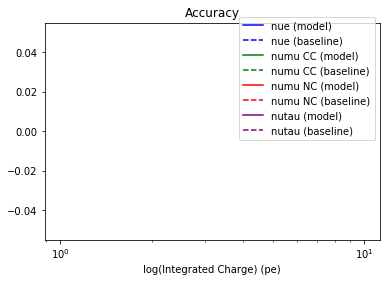

In [111]:
plot_metric('acc', 'Accuracy', )

In [112]:
(y_model == y_gnd).sum() / y_gnd.shape[0]

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


AttributeError: 'bool' object has no attribute 'sum'

In [113]:
(y_baseline == y_gnd).sum() / y_gnd.shape[0]

0.5603745065196966

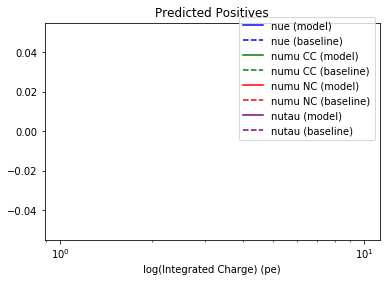

In [114]:
plot_metric('ppr', 'Predicted Positives')

In [81]:
bins_track, bin_counts_track = np.unique(binned[y_gnd > 0], return_counts=True)
bins_non_track, bin_counts_non_track = np.unique(binned[y_gnd <= 0], return_counts=True)
bin_counts_non_track, bin_counts_track


(array([  11,  187,  557, 1280, 1892, 2430, 2464, 2641, 2554, 2409, 2203,
        2023, 1736, 1578, 1370, 1185, 1032,  924,  775,  583,  542,  492,
         394,  336,  296,  239,  197,  157,  139,  101,   82,   77,   51,
          35,   26,   13,   10,    9,   14,    4,    4,    2,    1,    1,
           2]),
 array([  23,   77,  213,  393,  598,  819, 1140, 1300, 1591, 1804, 2036,
        2018, 2085, 2361, 2285, 2165, 2025, 1850, 1654, 1361, 1151,  928,
         717,  535,  371,  266,  162,   97,   66,   45,   28,   21,   10,
           6,    3,    1,    1,    1]))

Text(0.5, 0, 'log(Integrated Charge) (pe)')

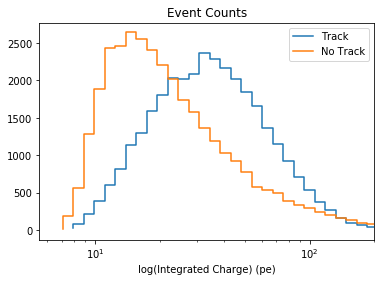

In [82]:
fig = plt.figure()
plt.xscale('log')
plt.step(bins[bins_track], bin_counts_track, label='Track')
plt.step(bins[bins_non_track], bin_counts_non_track, label='No Track')
plt.legend()
plt.xlim(right=2e2)
plt.title('Event Counts')
plt.xlabel('log(Integrated Charge) (pe)')

In [83]:
np.hstack((
    np.array(pd.DataFrame(metrics['numu CC']['model'])['acc']),
    np.array(pd.DataFrame(metrics['numu CC']['model'])['acc'])
    )
)

array([       nan,        nan, 0.69230769, 0.72340426, 0.675     ,
       0.77678571, 0.75561798, 0.75275938, 0.78338279, 0.80851064,
       0.81512605, 0.84995425, 0.85299003, 0.85873288, 0.85793212,
       0.84626437, 0.86868687, 0.84569288, 0.84494196, 0.84780739,
       0.83928571, 0.84166667, 0.80769231, 0.78230088, 0.80414747,
       0.70987654, 0.74568966, 0.68292683, 0.76086957, 0.70833333,
       0.7826087 , 0.78571429, 0.7       , 0.72727273, 0.75      ,
       1.        ,        nan,        nan, 1.        ,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.69230769, 0.72340426, 0.675     ,
       0.77678571, 0.75561798, 0.75275938, 0.78338279, 0.80851064,
       0.81512605, 0.84995425, 0.85299003, 0.85873288, 0.85793212,
       0.84626437, 0.86868687, 0.84569288, 0.84494196, 0.84780739,
       0.83928571, 0.84166667, 0.80769231, 0.78230088, 0.80414

In [84]:
total_charge_sorted = np.sort(total_charge)

In [19]:
# Find different cutoff values to check performance at different maximal energies by selecting the quantiles of the data
cutoffs = []
quantiles = []
for quantile in np.arange(0.00, 1.0, 0.01):
    quantile = 1.0 - quantile
    quantiles.append(quantile)
    cutoffs.append(total_charge_sorted[int(total_charge.shape[0] * quantile) - 1])

In [20]:
y_model.shape, y_gnd.shape

((220295,), (220295,))

In [22]:
metrics = defaultdict(lambda: defaultdict(list))
for cutoff, quantile in zip(cutoffs, quantiles):
    mask = total_charge <= cutoff
    acc_baseline, tpr_baseline, tnr_baseline, ppr_baseline = get_metrics(y_baseline[mask], y_gnd[mask])
    metrics['baseline']['accuracy'].append(acc_baseline)
    metrics['baseline']['tpr'].append(tpr_baseline)
    metrics['baseline']['tnr'].append(tnr_baseline)
    metrics['baseline']['ppr'].append(ppr_baseline)
    acc_model, tpr_model, tnr_model, ppr_model = get_metrics(y_model[mask], y_gnd[mask])
    metrics['model']['accuracy'].append(acc_model)
    metrics['model']['tpr'].append(tpr_model)
    metrics['model']['tnr'].append(tnr_model)
    metrics['model']['ppr'].append(ppr_model)
    metrics['gnd']['ppr'].append((y_gnd[mask] == 1).sum() / y_gnd[mask].shape[0])

Text(0.5, 0.04, 'Integrated Charge (pe)')

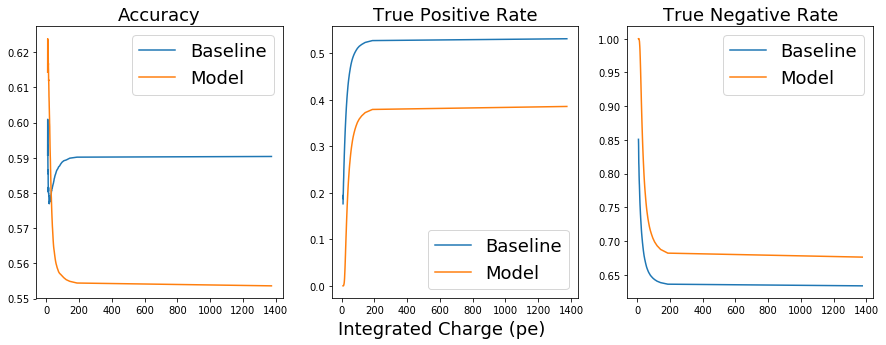

In [23]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax1.plot(cutoffs, metrics['baseline']['accuracy'], label='Baseline')
ax1.plot(cutoffs, metrics['model']['accuracy'], label='Model')
ax1.set_title('Accuracy', fontsize=18)
ax1.legend(fontsize=18)
ax2 = fig.add_subplot(132)
ax2.plot(cutoffs, metrics['baseline']['tpr'], label='Baseline')
ax2.plot(cutoffs, metrics['model']['tpr'], label='Model')
ax2.set_title('True Positive Rate', fontsize=18)
ax2.legend(fontsize=18)
ax3 = fig.add_subplot(133)
ax3.plot(cutoffs, metrics['baseline']['tnr'], label='Baseline')
ax3.plot(cutoffs, metrics['model']['tnr'], label='Model')
ax3.set_title('True Negative Rate', fontsize=18)
ax3.legend(fontsize=18)
fig.text(0.5, 0.04, 'Integrated Charge (pe)', ha='center', va='center', fontsize=18)



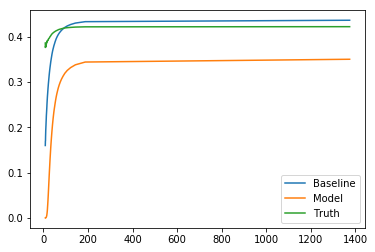

In [24]:
fig = plt.figure()
plt.plot(cutoffs, metrics['baseline']['ppr'], label='Baseline')
plt.plot(cutoffs, metrics['model']['ppr'], label='Model')
plt.plot(cutoffs, metrics['gnd']['ppr'], label='Truth')
plt.legend()


In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
adjacency_matrix_layer_1 (Ad multiple                  1         
_________________________________________________________________
gcnn_block_4 (GCNNBlock)     multiple                  1088      
_________________________________________________________________
gcnn_block_5 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
gcnn_block_6 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
gcnn_block_7 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
dense_2 (Dense)              multiple                  2080      
_________________________________________________________________
batch_normalization_v1_1 (Ba multiple                  128       
__________

In [32]:
model.weights

[<tf.Variable 'adjacency_matrix_layer_1/sigma:0' shape=(1,) dtype=float32, numpy=array([-1.1994079], dtype=float32)>,
 <tf.Variable 'gcnn_block_4/dense/kernel:0' shape=(16, 64) dtype=float32, numpy=
 array([[-6.7605382e-01, -5.5014306e-01,  1.0545670e+00, ...,
          5.9158012e-02,  4.1892594e-01,  1.1311057e+00],
        [-1.1726910e-01, -3.6698148e-02, -2.5776282e-02, ...,
         -1.6091052e-01, -3.3308864e-03,  1.9296408e-02],
        [-4.5562524e-01, -7.2932534e-02,  3.4593046e-01, ...,
         -2.7987896e-02,  1.9500892e-01,  7.2564250e-01],
        ...,
        [ 2.4853425e-02,  5.2007634e-02,  1.5153764e-04, ...,
         -1.7101361e-01,  9.0077855e-03, -3.0158782e-01],
        [ 1.8562905e-01, -2.1861477e-01, -2.6344028e-01, ...,
         -1.6159213e-01,  5.9850786e-02, -1.6955628e-01],
        [ 1.4021096e-01, -1.9073695e-01, -1.7653483e-01, ...,
          9.7623197e-03, -1.5720429e-02, -1.2895808e-01]], dtype=float32)>,
 <tf.Variable 'gcnn_block_4/dense/bias:0' shape=(6

In [131]:
np.unique(y_model)

array([0])

# Investigate attributes of the dataset

In [5]:
file = h5py.File('../data/data_dragon2.hd5')

In [13]:
idx = np.arange(file['TimeStdDeviation'].shape[0])
np.random.shuffle(idx)

In [14]:
samples = idx[:100000]

In [18]:
file.keys()

<KeysViewHDF5 ['ChargeFirstPulse', 'ChargeLastPulse', 'DeltaLLH', 'IC86_Dunkman_L6_SANTA_DirectCharge', 'IntegratedCharge', 'InteractionType', 'NumberChannels', 'NumberVertices', 'Offset', 'PDGEncoding', 'RecoAzimuth', 'RecoX', 'RecoY', 'RecoZ', 'RecoZenith', 'TimeFirstPulse', 'TimeLastPulse', 'TimeStdDeviation', 'TotalCharge', 'VertexX', 'VertexY', 'VertexZ', '__I3Index__']>

In [42]:
time_std_samples = file['TimeStdDeviation']['item'][samples]

In [38]:
time_std_samples = time_std_samples[time_std_samples < 1e-5]

In [43]:
time_std_samples

array([1.2055448e-03, 1.1102230e-16, 0.0000000e+00, ..., 0.0000000e+00,
       0.0000000e+00, 2.8057413e-03], dtype=float32)

(array([76768.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  4604.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,   264.]),
 array([0.00000000e+00, 2.22044600e-18, 4.44089200e-18, 6.66133800e-18,
        8.88178400e-18

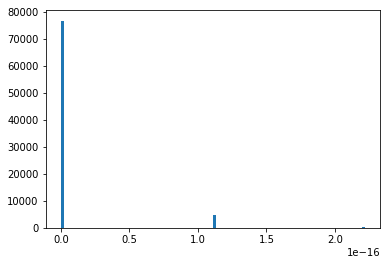

In [39]:
plt.hist(time_std_samples, bins=100)

In [40]:
charge_samples = file['ChargeFirstPulse']['item'][samples]

In [27]:
charge_samples = charge_samples[charge_samples <= 5]

(array([3072., 3387., 3761., 4108., 4557., 5143., 5673., 5869., 6233.,
           0., 6162., 6139., 5778., 5318., 4768., 4331., 3793., 3172.,
           0., 2688., 2301., 1654., 1348., 1078.,  891.,  731.,  589.,
           0.,  528.,  435.,  373.,  360.,  345.,  307.,  296.,  278.,
           0.,  259.,  222.,  214.,  202.,  214.,  174.,  185.,  134.,
           0.,  137.,  121.,  134.,   90.,  136.,   94.,   87.,   85.,
           0.,   75.,   86.,   84.,   47.,   75.,   48.,   55.,   42.,
           0.,   39.,   36.,   49.,   49.,   39.,   48.,   36.,   37.,
           0.,   32.,   27.,   32.,   32.,   41.,   35.,   43.,   27.,
           0.,   28.,   21.,   21.,   24.,   27.,   20.,   18.,   13.,
           0.,   24.,   15.,   21.,   18.,   13.,   21.,   15.,   14.,
          11.]),
 array([0.525     , 0.56949997, 0.61399996, 0.65849996, 0.70299995,
        0.74749994, 0.792     , 0.8365    , 0.881     , 0.9255    ,
        0.96999997, 1.0145    , 1.059     , 1.1035    , 1.148     

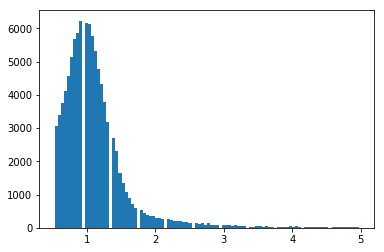

In [29]:
plt.hist(charge_samples, bins=100)

In [48]:
time_samples = file['TimeFirstPulse']['item'][samples]

In [51]:
time_samples_filtered = time_samples[time_samples > -0.002]

In [55]:
time_samples_filtered.std()

0.00030537526